In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re


In [2]:
with open("data/code/opcode_list.txt",'r') as F:
    OPCODES = F.read().split()

In [3]:
rawdf = pd.read_csv("ContractAddr.csv",sep='\t')
rawdf[OPCODES] = 0
rawdf

,addr,IS_PONZI,STOP,ADD,MUL,SUB,DIV,SDIV,MOD,SMOD,...,CALLCODE,RETURN,DELEGATECALL,STATICCALL,REVERT,INVALID,SELFDESTRUCT,RETURNSUB,BEGINSUB,JUMPSUB
0,0x0006157838d5a6b33ab66588a6a693a57c869999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0x001a589dda0d6be37632925eaf1256986b2c6ad0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0x00674045bb7c17f0aa1cde34780d6c51af548728,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x006bea43baa3f7a6f765f14f10a1a1b08334ef45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0x00712a531e207ad77e42586fb81e9fb8f68f0a7d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,0xf52ecc525d998eb880911a268b0fa4bc7d69a435,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,0xf8f04b23dace12841343ecf0e06124354515cc42,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,0xf91446ead6aadd4321602b5790a6db4d6f2a1930,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3882,0xfad05ee13c8e0ec94e5ee9dc056dc451b2ad6b1d,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_ponzi = rawdf[rawdf["IS_PONZI"]==1]
df_not_ponzi = rawdf[rawdf["IS_PONZI"]==0]

df_ponzi.count(), df_not_ponzi.count()

(addr            298
 IS_PONZI        298
 STOP            298
 ADD             298
 MUL             298
                ... 
 INVALID         298
 SELFDESTRUCT    298
 RETURNSUB       298
 BEGINSUB        298
 JUMPSUB         298
 Length: 81, dtype: int64,
 addr            3586
 IS_PONZI        3586
 STOP            3586
 ADD             3586
 MUL             3586
                 ... 
 INVALID         3586
 SELFDESTRUCT    3586
 RETURNSUB       3586
 BEGINSUB        3586
 JUMPSUB         3586
 Length: 81, dtype: int64)

In [5]:
def opcodePreprocess(opcode:str):
    if not opcode.startswith("opcode"):
        return re.sub(r'[0-9]', '', opcode)
    else:
        return None
     

In [6]:
def ByteCodeReader(df: pd.DataFrame,common=15)->dict:
    bytecodes = []
    addrs = df["addr"].tolist()
    for addr in addrs:
        bytecode = []
        with open("./data/code/opcode/{}.txt".format(addr),'r') as F:
            # Ignore first line
            for line in F.readlines()[1:]:
                operation:str = opcodePreprocess(line.split()[1])
                if operation!=None:
                    bytecode.append(operation)
        bytecodes.extend(bytecode)
    counter = Counter(bytecodes)
    mc = list(zip(*counter.most_common(common)))
    return {"op":np.array(mc[0]),"val":np.array(mc[1])/sum(counter.values())}
            
                



Text(0.5, 1.0, 'non-ponzi')

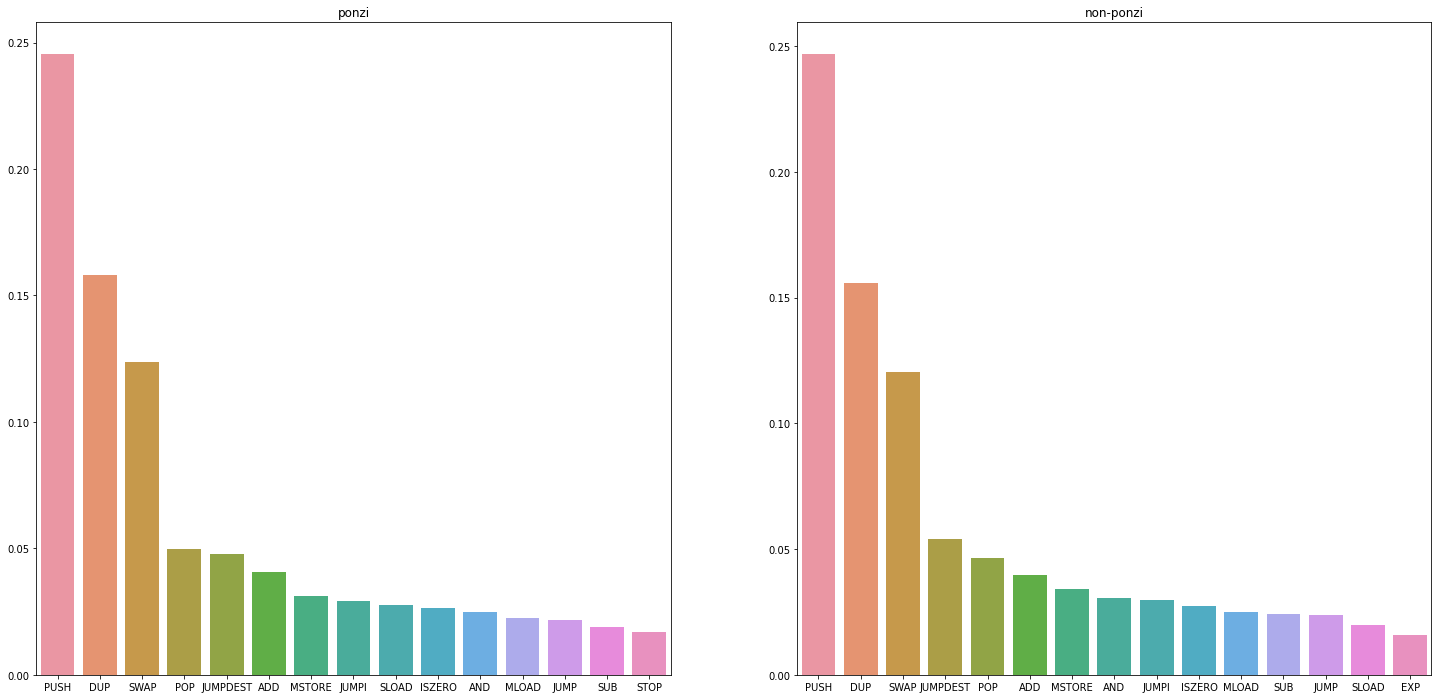

In [7]:
pdict = ByteCodeReader(df_ponzi)
npdict = ByteCodeReader(df_not_ponzi)
f, axes = plt.subplots(1, 2, figsize=(25,12))
sns.barplot(x="op",y="val",data=pdict , ax=axes[0]).set_title('ponzi')
sns.barplot(x="op",y="val",data=npdict , ax=axes[1]).set_title('non-ponzi')

In [8]:
def ByteCodeFiller(df: pd.DataFrame):
    copy_df = df.copy()
    for i in range(len(copy_df)):
        addr = copy_df["addr"][i]
        with open("./data/code/opcode/{}.txt".format(addr),'r') as F:
            # Ignore first line
            for line in F.readlines()[1:]:
                operation:str = opcodePreprocess(line.split()[1])
                if operation!=None:
                    copy_df.at[i,operation] = copy_df.at[i,operation] + 1
    copy_df.to_csv("./data/code/code_features.csv",index=False)
ByteCodeFiller(rawdf)

# Draw distribution of code features

In [ ]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

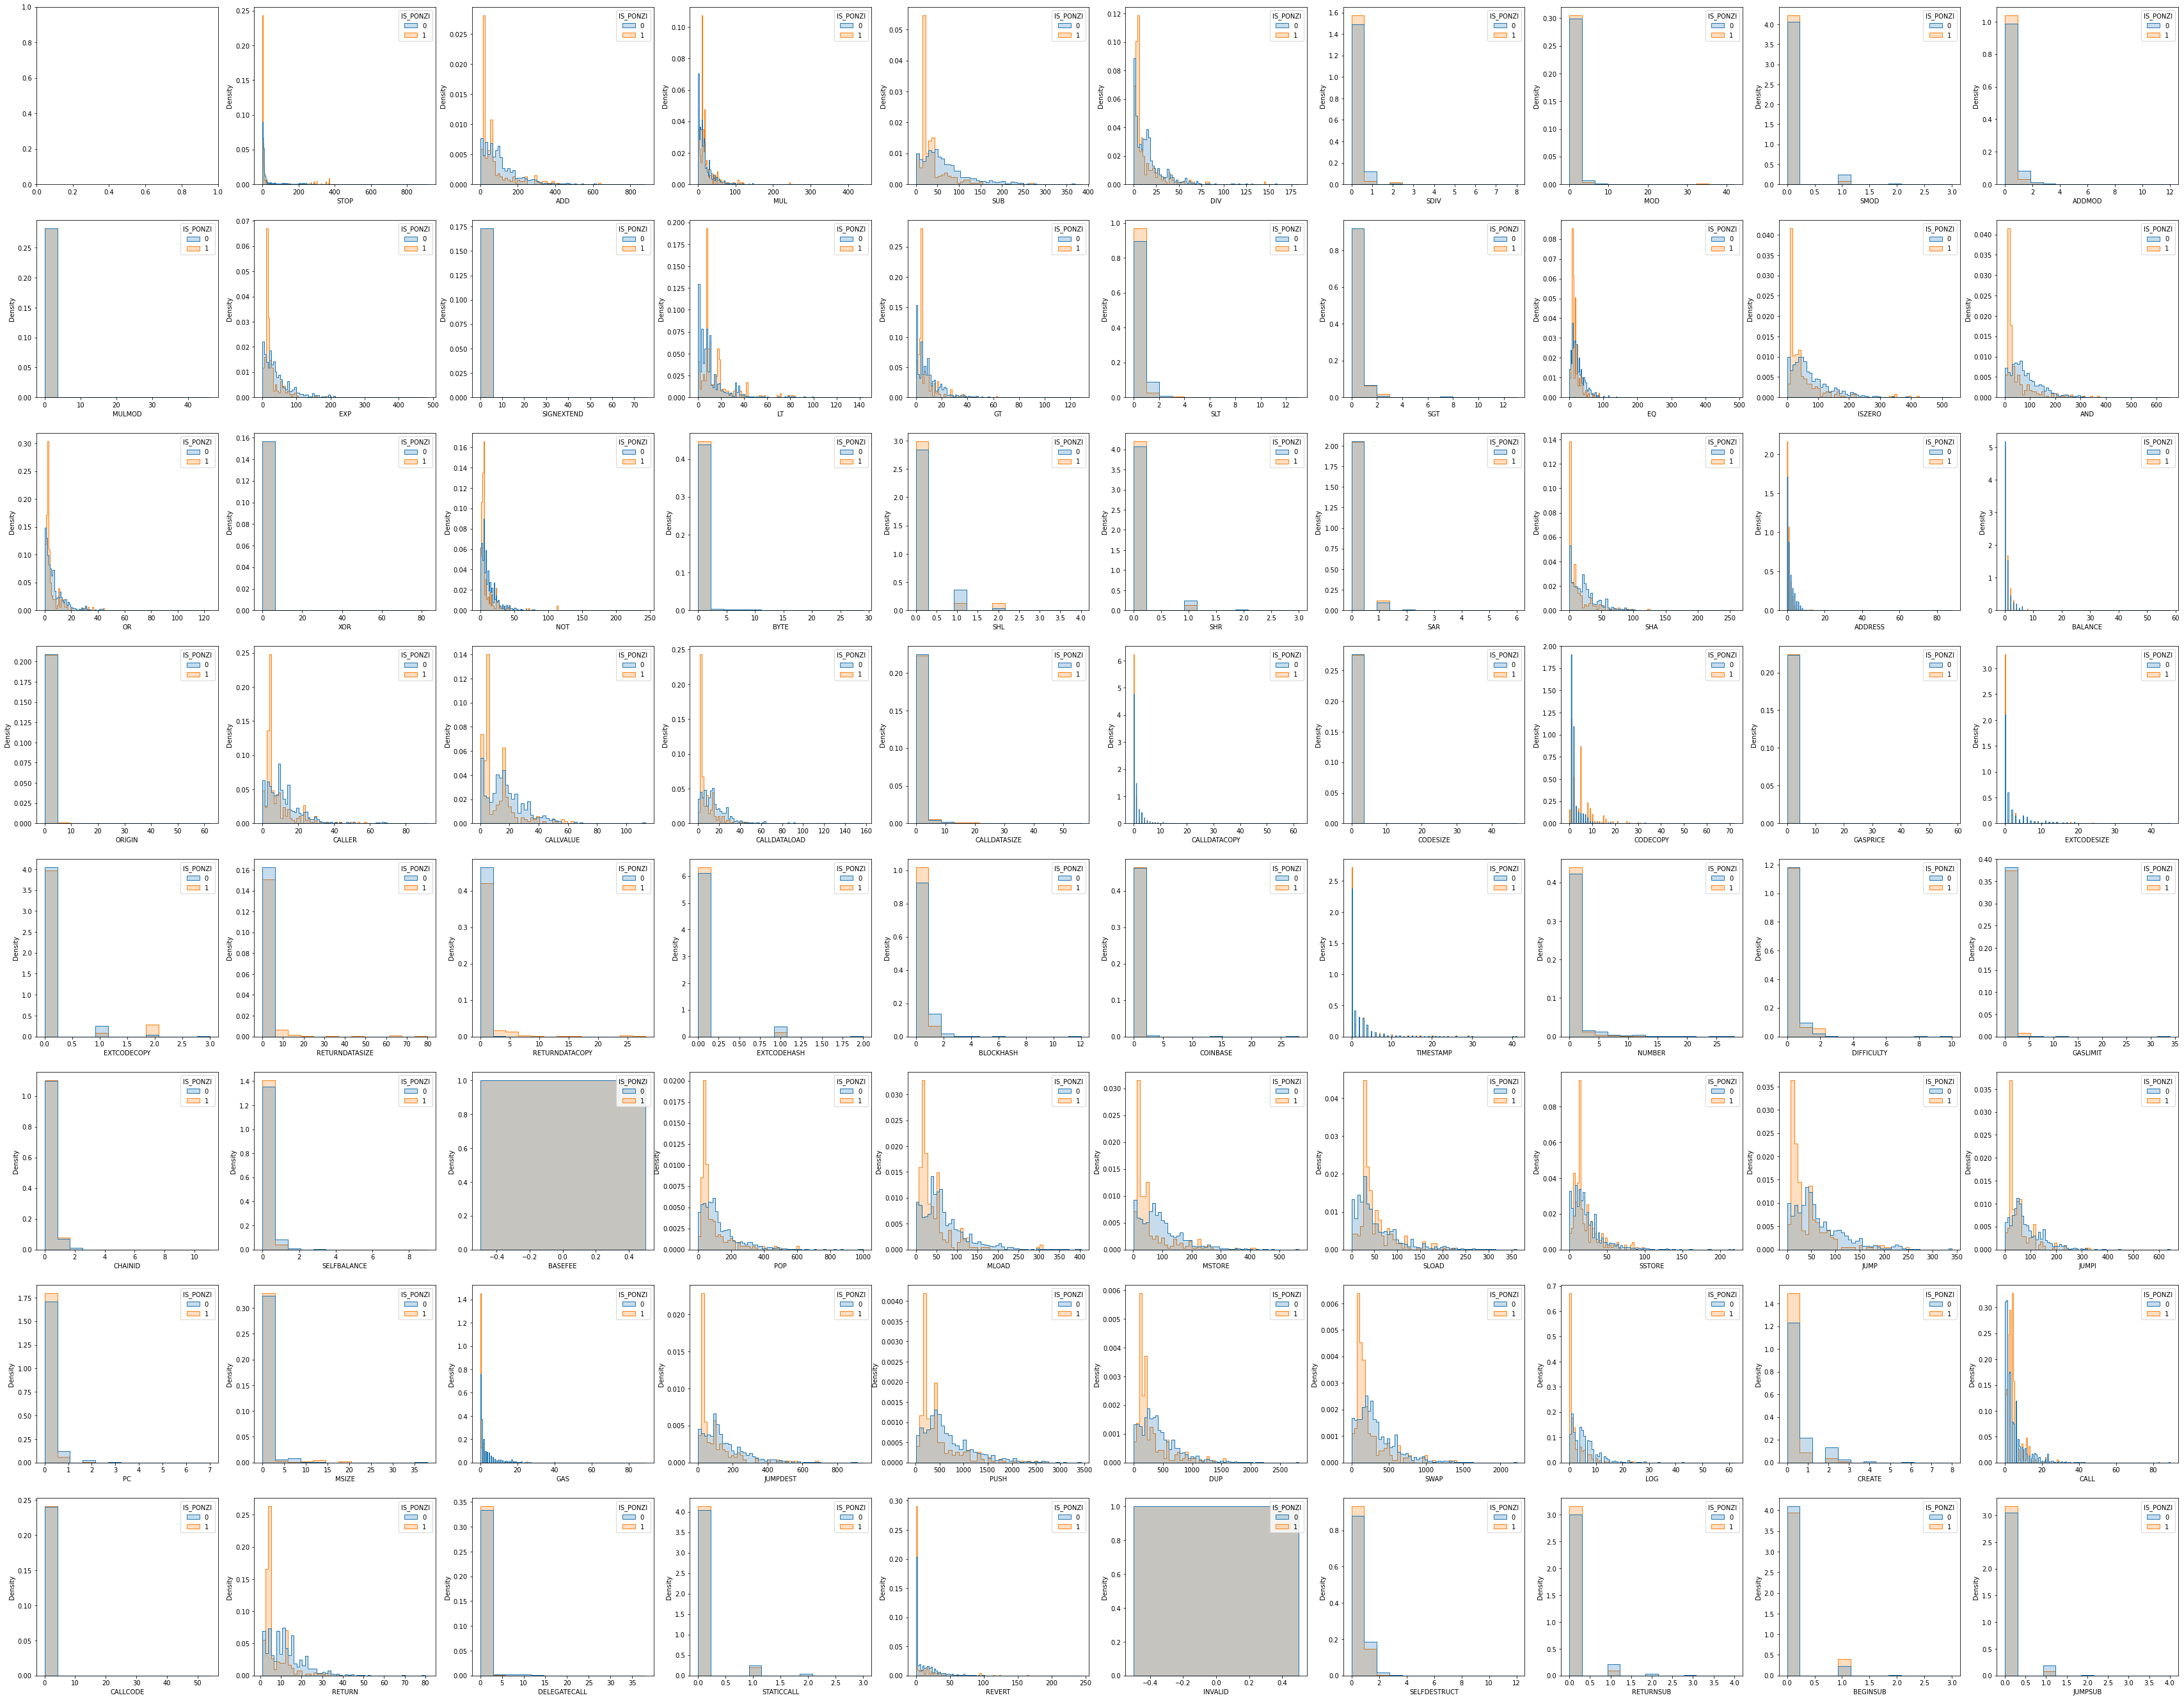

In [28]:
df = pd.read_csv("data/code/code_features.csv",)
df.drop(df.columns[[0]], axis=1, inplace=True)

# 80-1 columns
fig, axes = plt.subplots(ncols=10, nrows=8,figsize=(60,48))
for column, ax in zip(df.columns, axes.flat):
    if(column=="IS_PONZI"): continue
    sns.histplot(
    df, x=column, hue="IS_PONZI", element="step",  stat="density", common_norm=False,  ax=ax,)
fig.savefig("./image/opcode_ponzi_compare.jpg")

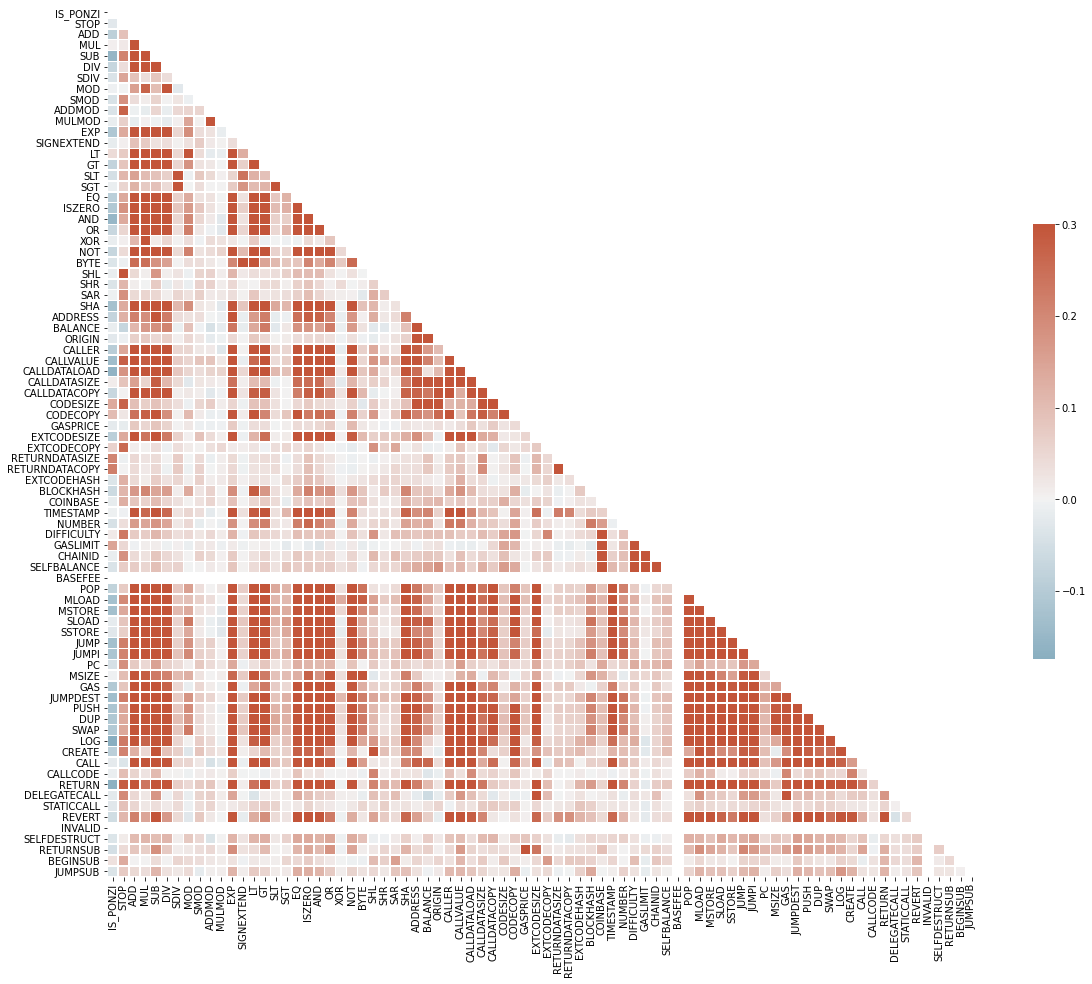

In [33]:
# Correlation plot

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f.savefig("./image/corr.jpg")
